In [31]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE

In [32]:
# fulldata_withPP - all samples, no columns removed due to NAs, preprocessing for weasel answers
# procdata_withPP - light cleaning
# mostdata_withPP - imputation on reduced set, 2% least filled removed
# lessdata_withPP - imputation on reduced set (% lesast filled), but only retain 2/3 filled out data
# core_withPP - just the representative cross-section core
Treatment = "uptodate/"
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)


In [33]:
fname = BES_data_folder+"cat_dictionary"+".pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
print("cat_dictionary", len( cat_dictionary ) )

cat_dictionary 650


In [34]:
var_type    = pd.read_hdf( BES_data_folder+"var_type.hdf", "var_type" )
print("var_type",  var_type.shape )

var_type (733, 1)


In [35]:
BES_reduced = pd.read_hdf(BES_data_folder+"BES_reduced.hdf","BES_reduced")
print("BES_reduced",  BES_reduced.shape )

BES_numeric = pd.read_hdf( BES_data_folder+"BESW8numeric.hdf", "BESW8numeric" )
print("BES_numeric",  BES_numeric.shape )

BES_reduced (31409, 454)
BES_numeric (31409, 659)


In [64]:
BES_reduced_with_na = pd.read_hdf(BES_data_folder+"BES_reduced_with_na.hdf","BES_reduced_with_na")
print("BES_reduced_with_na",  BES_reduced.shape )

# load decomp object
fname = BES_data_folder+"new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f)     

BES_reduced_with_na (31409, 454)


In [37]:
# # reduce to representative core
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
# BES_reduced = BES_reduced.loc[ BES_Panel['wt_core_W8'].notnull() , : ]
# BES_numeric = BES_numeric.loc[ BES_Panel['wt_core_W8'].notnull() , : ]

In [38]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

In [39]:
%%time
## RUN (some variant of) PCA (potentially v slow!)

# (svd_solver='full', n_components='mle',whiten=True)
#decomp = PCA(svd_solver='full')
#decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
 #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr
decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
# ,n_components=30

X_r = decomp.fit_transform(BES_std)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)


Wall time: 7.77 s


In [40]:
# SAVE decomp results
suff = str(decomp).split("(")[0]

decomp_method = suff+"/"
if not os.path.exists(BES_data_folder+Treatment+decomp_method):
    os.makedirs(BES_data_folder+Treatment+decomp_method)

# save decomp object    
fname = BES_data_folder+Treatment+decomp_method+suff+".pkl"
with open(fname, "wb") as f:
    pickle.dump( decomp, f )

# save BES_decomp
fname = BES_data_folder+Treatment+decomp_method+suff+".hdf"
BES_decomp.to_hdf(fname,suff)

# save BES_std
fname = BES_data_folder+Treatment+decomp_method+suff+"_std"+".hdf"
BES_decomp.to_hdf(fname,suff)

In [41]:
# LOAD decomp results (default does not)
if False or ( 'decomp' not in globals() ):

    suff = "FactorAnalysis"
    print("Loading: ",suff)
    decomp_method = suff+"/"
    if not os.path.exists(BES_data_folder+Treatment+decomp_method):
        os.makedirs(BES_data_folder+Treatment+decomp_method)

    # load decomp object
    fname = BES_data_folder+Treatment+decomp_method+suff+".pkl"
    with open(fname, "rb") as f:
        decomp = pickle.load(f) 

    # load BES_decomp
    fname = BES_data_folder+Treatment+decomp_method+suff+".hdf"
    BES_decomp = pd.read_hdf(fname)
    
    # load BES_std
    fname = BES_data_folder+Treatment+decomp_method+suff+"_std"+".hdf"
    BES_std = pd.read_hdf(fname)    

    n_components = decomp.components_.shape[0]

average log-likelihood of all samples: -553.3288632854208
number of iterations: 3


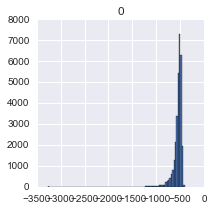

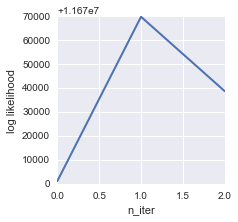

In [42]:
figsz = (3,3)

if hasattr(decomp, 'explained_variance_ratio_'):
    print('explained variance ratio (first 30): %s'
          % str(decomp.explained_variance_ratio_[0:30]) )
    
if hasattr(decomp, 'explained_variance_'):
    print('explained variance (first 30): %s'
          % str(decomp.explained_variance_[0:30]) )
    plt.figure(figsize = figsz)
    plt.plot( range(1,n_components+1), decomp.explained_variance_, linewidth=2)
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_') 
    
if hasattr(decomp, 'noise_variance_'): 
    if isinstance(decomp.noise_variance_, float):
        print('noise variance: %s'
              % str(decomp.noise_variance_) )
    
if hasattr(decomp, 'score'):
    print('average log-likelihood of all samples: %s'
          % str(decomp.score(BES_std)) )
    
if hasattr(decomp, 'score_samples') and not np.isinf( decomp.score(BES_std) ):
    pd.DataFrame( decomp.score_samples(BES_std) ).hist(bins=100,figsize = figsz)

if hasattr(decomp, 'n_iter_'):
    print('number of iterations: %s'
          % str(decomp.n_iter_) )
    
if hasattr(decomp, 'loglike_'):
    plt.figure(figsize = figsz)
    plt.plot( decomp.loglike_, linewidth=2 )
    plt.xlabel('n_iter')
    plt.ylabel('log likelihood') 

if hasattr(decomp, 'error_'):
    plt.figure(figsize = figsz)
    plt.plot( decomp.error_, linewidth=2)
    plt.xlabel('n_iter')
    plt.ylabel('error') 

In [43]:
# 0.07954041   0.03892755   0.03553862   0.01885494    0.01562524  
# 50.4286187   24.68006591  22.53148776  11.95403344   9.90639926

In [44]:
decomp

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='lapack',
        tol=0.01)

Wall time: 14.2 s


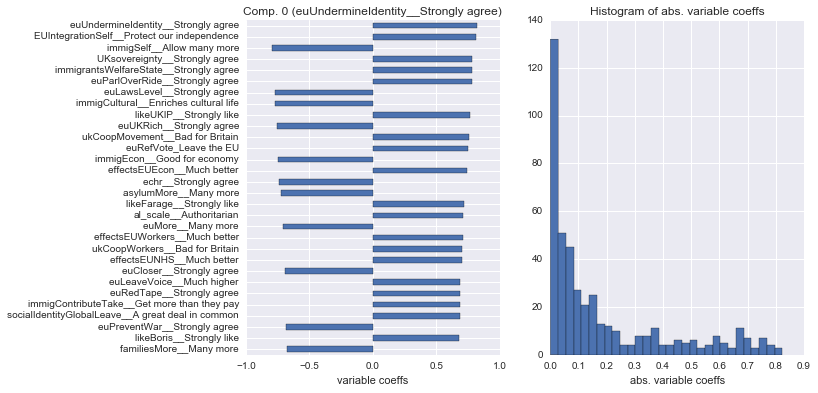

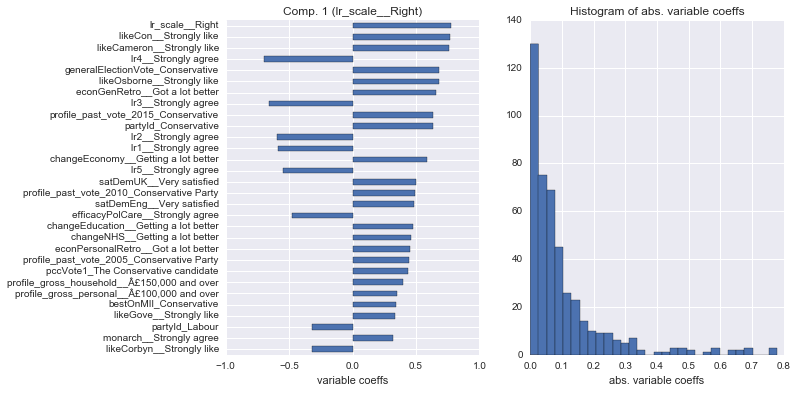

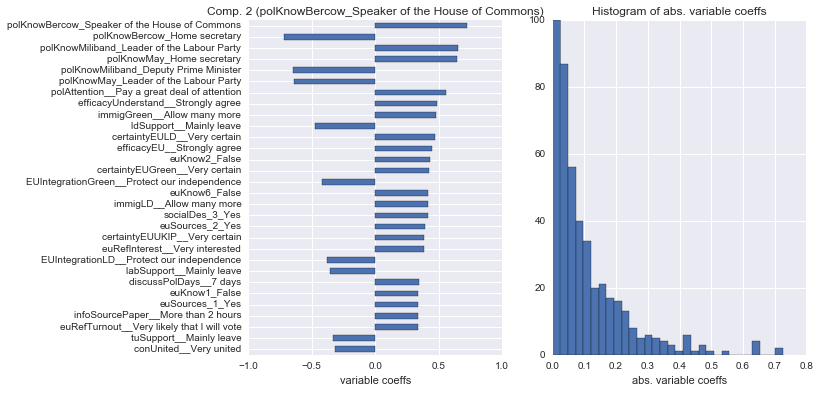

In [45]:
%%time

graph_type = "decomposition_axes/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

n_comps = min(n_components,20)
comp_labels = {}

for comp_no in range(0,n_comps):

    fig, axes = plt.subplots(ncols=2)
    
    ax = axes[1]
    comp = pd.DataFrame( decomp.components_[comp_no], index = BES_reduced.columns, columns = ["components_"] )
    comp["comp_absmag"] = comp["components_"].abs()
    comp = comp.sort_values(by="comp_absmag",ascending=True)
    ax.set_xlabel("abs. variable coeffs")
    ax.set_title("Histogram of abs. variable coeffs")
    comp["comp_absmag"].hist( bins=30, ax=ax, figsize=(10,6) )

    # set top abs_mag variable to label
    comp_labels[comp_no] = comp.index[-1:][0] # last label (= highest magnitude)
    # if top abs_mag variable is negative
    if comp[-1:]["components_"].values[0] < 0:
        comp["components_"]         = -comp["components_"]
        decomp.components_[comp_no] = -decomp.components_[comp_no]
        BES_decomp[comp_no]         = -BES_decomp[comp_no]

    ax = axes[0]
    title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
    comp_labels[comp_no] = title
    ax.set_title( title )
    ax.set_xlabel("variable coeffs")
    xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
    comp["components_"].tail(30).plot( kind='barh', ax=ax,figsize=(10,6), xlim=xlim )

    fname = folder + title.replace("/","_") +".png"
    fig.savefig( fname, bbox_inches='tight' )
    
    if comp_no >2:
        plt.close()

In [46]:
x_axis = 0
y_axis = 1

xlim = np.floor( BES_decomp.loc[ :, x_axis ].min() ), np.ceil( BES_decomp.loc[ :, x_axis ].max() )
ylim = np.floor( BES_decomp.loc[ :, y_axis ].min() ), np.ceil( BES_decomp.loc[ :, y_axis ].max() )

if suff == 'SparsePCA':
    xlim =  BES_decomp.loc[ :, x_axis ].min() ,  BES_decomp.loc[ :, x_axis ].max() 
    ylim =  BES_decomp.loc[ :, y_axis ].min() ,  BES_decomp.loc[ :, y_axis ].max() 

In [48]:
# BES_decomp.index
# BES_reduced.loc[BES_decomp.index,decomp_label_col].shape

In [49]:
# # for ordinal categorical
# # winter, autumn
# cmap_name = "winter"
# decomp_label_col = 'lr_scale__Right'
# label_stub = decomp_label_col.split("__")[0]

# fig = plt.figure( figsize=(16,10) )
# plt.scatter(BES_decomp.loc[ :, x_axis ],
#             BES_decomp.loc[ :, y_axis ],
#             cmap = plt.get_cmap(cmap_name),
#             c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
#             edgecolor = "None",
#             alpha = 0.9) #            edgecolors=col,

# plt.xlim(xlim)
# plt.ylim(ylim)

# cats = cat_dictionary[ label_stub ]
# labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
# plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
# plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
# plt.xlabel( comp_labels[x_axis] )
# plt.ylabel( comp_labels[y_axis] ) 
# plt.show()

# fig.savefig( BES_data_folder+Treatment+decomp_method+label_stub+".png", bbox_inches='tight' )

In [50]:
# # for ordinal categorical
# # winter, autumn
# cmap_name = "winter"
# decomp_label_col = 'al_scale__Authoritarian'
# label_stub = decomp_label_col.split("__")[0]

# fig = plt.figure( figsize=(16,10) )
# plt.scatter(BES_decomp.loc[ :, x_axis ],
#             BES_decomp.loc[ :, y_axis ],
#             cmap = plt.get_cmap(cmap_name),
#             c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
#             edgecolor = "None",
#             alpha = 0.9) #            edgecolors=col,

# plt.xlim(xlim)
# plt.ylim(ylim)

# cats = cat_dictionary[ label_stub ]
# labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
# plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
# plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
# plt.xlabel( comp_labels[x_axis] )
# plt.ylabel( comp_labels[y_axis] ) 
# plt.show()

# fig.savefig( BES_data_folder+Treatment+decomp_method+label_stub+".png", bbox_inches='tight' )

noise_variance_
lr_scale__Right                                            0.094153
al_scale__Authoritarian                                    0.106772
likeCon__Strongly like                                     0.164078
likeUKIP__Strongly like                                    0.174829
polKnowBercow_Speaker of the House of Commons              0.184317
polKnowBercow_Home secretary                               0.185034
polKnowMiliband_Deputy Prime Minister                      0.199685
polKnowMiliband_Leader of the Labour Party                 0.199856
country_England                                            0.200479
immigSelf__Allow many more                                 0.208202
likeCameron__Strongly like                                 0.209224
polKnowMay_Home secretary                                  0.210254
polKnowMay_Leader of the Labour Party                      0.210745
likeFarage__Strongly like                                  0.213401
countryOfBirth_England                                     0.226378
likeLab__Strongly like                                     0.229167
edlevel__Postgrad                                          0.231399
EUIntegrationSelf__Protect our independence                0.234955
immigEcon__Good for economy                                0.239929
effectsEUEcon__Much better                                 0.240336
gor_Scotland                                               0.248879
generalElectionVote_Conservative                           0.248911
prevJob_Yes, I have done paid work in the past             0.250114
euUndermineIdentity__Strongly agree                        0.252950
immigrantsWelfareState__Strongly agree                     0.257678
euRefVote_Leave the EU                                     0.261914
likeCorbyn__Strongly like                                  0.262921
immigCultural__Enriches cultural life                      0.263773
euMore__Many more                                          0.266722
partyId_Conservative                                       0.269773
...                                                             ...
euMIISmall_Campaign/outcome fairness                       0.877917
education_Scottish Ordinary/ Lower Certificate             0.879869
profile_newspaper_readership_201_The Express               0.880763
profile_ethnicity_Any other Asian background               0.882357
education_Recognised trade apprenticeship compl...         0.883693
housing_Own (part-own) through shared ownership...         0.884992
profile_ethnicity_White and Asian                          0.886477
euRefFinal_There might be a second referendum              0.887746
profile_newspaper_readership_201_The Scotsman              0.888085
euMIISmall_No content to reason                            0.888944
education_Nursing qualification (eg SEN, SRN, S...         0.889336
euGovtLeaflet_Yes, received but not read it                0.889400
profile_ethnicity_Any other mixed background               0.890850
profile_religion_Yes - Free Presbyterian                   0.898567
profile_newspaper_readership_201_The Daily Star...         0.899720
marital_Civil Partnership                                  0.904419
bestOnMII_Other party                                      0.904789
euMIISmall_EU spending/regulations/cost                    0.910214
education_Youth training certificate/skillseekers          0.911403
profile_ethnicity_White and Black African                  0.911648
euMIISmall_Social identity/partisanship                    0.912895
profile_newspaper_readership_201_The Financial ...         0.915557
countryOfBirth_Northern Ireland                            0.917870
education_onc                                              0.917919
profile_past_vote_2015_British National Party (...         0.924180
euMIISmall_Other stability or uncertainty concern          0.924564
profile_ethnicity_Any other black background               0.928071
euMIISmall_Family                       

noise_variance_
bestOnMII_Other party                                      0.904789
countryOfBirth_Northern Ireland                            0.917870
education_Youth training certificate/skillseekers          0.911403
education_onc                                              0.917919
euMIISmall_EU integration/stability                        0.934344
euMIISmall_EU spending/regulations/cost                    0.910214
euMIISmall_Family                                          0.934344
euMIISmall_Other stability or uncertainty concern          0.924564
euMIISmall_Social identity/partisanship                    0.912895
marital_Civil Partnership                                  0.904419
profile_ethnicity_Any other black background               0.928071
profile_ethnicity_White and Black African                  0.911648
profile_newspaper_readership_201_The Financial ...         0.915557
profile_past_vote_2005_Veritas                             0.945520
profile_past_vote_2015_British National Party (...         0.924180

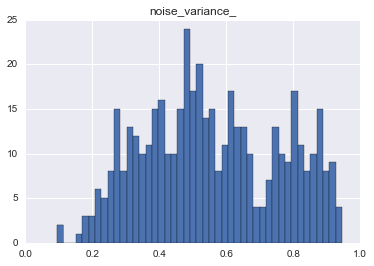

In [51]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [52]:
# # who are the "improbables"?

# if hasattr(decomp, 'score_samples'):
#     most_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.999).values[0]
#     least_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.001).values[0]
#     print("least likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)<least_likely] ])
# # who are the "stereotypes"?
#     print("most likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)>most_likely ] ])
# # check to see balance of missing values!

number of estimated clusters : 1


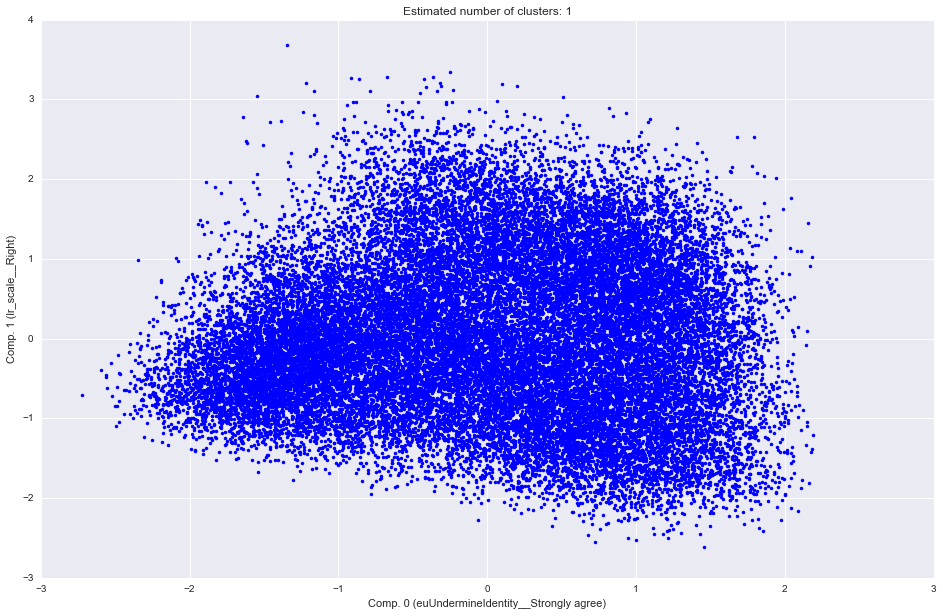

In [53]:
# %%time
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

X = X_r

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.')
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

fig.savefig(BES_data_folder+Treatment+decomp_method+"Cluster_estimation.png",bbox_inches='tight')


In [54]:
colours = cycle('ycmkgbr')
markers = cycle('v^<>,oD*x+')

cat_col_mar_dict = {} # category-colour-marker dictionary
# basic set of common ones! 
cat_col_mar_dict['Conservative'] = ('b', '.')
cat_col_mar_dict['Conservative Party'] = ('b', '.')
cat_col_mar_dict['The Conservative candidate']       = ('b', '.')
cat_col_mar_dict['Labour']       = ('r', '.')
cat_col_mar_dict['Labour Party']       = ('r', '.')
cat_col_mar_dict['The Labour candidate']       = ('r', '.')
cat_col_mar_dict['Green Party']  = ('g', '.')
cat_col_mar_dict['The Green candidate']       = ('g', '.')
cat_col_mar_dict['Plaid Cymru']  = ('k', '.')
cat_col_mar_dict['The Plaid Cymru candidate']  = ('k', '.')
cat_col_mar_dict['Scottish National Party']           = ('c', '.')
cat_col_mar_dict['United Kingdom Independence Party'] = ('m', '.')
cat_col_mar_dict['The UKIP candidate'] = ('m', '.')
cat_col_mar_dict['Liberal Democrat']                         = ('orange', '.')
cat_col_mar_dict['Liberal Democrats']                        = ('orange', '.')
cat_col_mar_dict['The Liberal Democrat candidate']                         = ('orange', '.')

In [55]:
# BES_reduced.columns

In [56]:
# BES_Panel["riskScale"]

In [57]:
# [ x for x in BES_reduced.columns if re.match(decomp_label_col + "(__)?", x) ]

# # re.match(decomp_label_col + "__", )

In [69]:
decomp_label_categories

['euSources_1_Yes', 'euSources_111_Yes']

In [68]:
# %%time

graph_type = "ordinal_scatter/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)
    

cmap_name = "winter"
    
dummy_list = var_type[ [ x in [ 0, 1, 2, 5, 6 ] for x in var_type["type"]  ] ].index # 0, 1, 2, 5, 6.index # ordinal variables

# ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
#     if decomp_label_col in ["profile_religion","country",
#                             'polKnowMay','polKnowOsborne',
#                             'polKnowClegg', 'polKnowBercow',
#                             'polKnowMiliband', 'registered', 'ns_sec']:
#         continue
    
    fig = plt.figure( figsize=(16,10) )

#     # go through all the variables that have been created from base variables through transformation
#     # for ordinal variables, these should only ever be unique matches (unlike non-ordinals)
#     decomp_label_categories = [ x for x in BES_reduced.columns if re.match(decomp_label_col + "_?_?", x) ]
#     if len(decomp_label_categories) == 0: # removed during transformation/reduction
#         continue
#     elif len(decomp_label_categories) > 1:
#         raise Exception('len(decomp_label_categories) > 1 !!!')
#     # c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
    
    if (decomp_label_col not in BES_reduced.columns):
        if decomp_label_col in new_old_col_names.keys(): # variable renamed in transformation
            decomp_label_categories = new_old_col_names[decomp_label_col]
        else:
            continue ## variable removed in transformation
    else:
        decomp_label_categories = decomp_label_col
    
    label_stub = decomp_label_col

    plt.scatter(BES_decomp.loc[ :, x_axis ],
                BES_decomp.loc[ :, y_axis ],
                cmap = plt.get_cmap(cmap_name),
                c = BES_reduced.loc[ BES_decomp.index , decomp_label_categories.values],
                edgecolor = "None",
                alpha = 0.9) #            edgecolors=col,

    plt.xlim(xlim)
    plt.ylim(ylim)

    # get category labels for categorical variables
    if var_type.loc[label_stub,"type"] in [ 1, 2, 5, 6 ]:
        cats = cat_dictionary[ label_stub ]
        labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
    elif var_type.loc[label_stub,"type"] in [ 0 ]:
        vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories.values]
        labels = ( "min val", min(vals), "max val", max(vals) )
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')
        
    plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
    plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
#     plt.show()
    
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1
#     print(fig_no)

C:\ANACON~1\envs\BES_analysis\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


AttributeError: 'list' object has no attribute 'values'

In [ ]:
%%time

graph_type = "non_ordinal_scatter/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered', 'ns_sec']:
        continue
    
    fig = plt.figure( figsize=(16,10) )

    decomp_label_categories = [ x for x in BES_reduced.columns if (decomp_label_col + "_") in x ]
    if len(decomp_label_categories) == 0:
        continue

    # 'No party is best able to handle this issue'
    drop_cat_list = ['profile_education_age', 'profile_ethnicity_White British']
    for drop_cat in drop_cat_list:
        if drop_cat in decomp_label_categories:
            decomp_label_categories.remove(drop_cat)
            
    replace_dict = {'Scottish National Party (SNP)' : 'Scottish National Party',
                    'United Kingdom Independence Party (UKIP)' : 'United Kingdom Independence Party'}

    lab_to_cat = {}
    sample_sizes = {}
    for cat in decomp_label_categories:
        
        lab = re.search('_([^_]+)$',cat).groups()[0]
        if lab in replace_dict.keys(): # replace party name variants with single version
            lab = replace_dict[lab]
        
        if lab not in cat_col_mar_dict.keys(): # try to give parties consistent colour, marker pairs
            cat_col_mar_dict[lab] = (next(colours),next(markers))
        
        sample_sizes[lab] = sum( BES_reduced[ cat ]==1 )
        lab_to_cat[lab] = cat

    for lab in sorted(sample_sizes, key=sample_sizes.get, reverse=True):
        
        samp = sample_sizes[lab]
            
        (col, mar) = cat_col_mar_dict[lab]

        cat_entries = BES_reduced[ lab_to_cat[lab] ]==1
        
        plt.scatter(BES_decomp.loc[ cat_entries, x_axis ],
                    BES_decomp.loc[ cat_entries, y_axis ],
                    c= col,
                    marker=mar,
                    label=lab + "(N="+str(samp)+")",
                    edgecolors=col,
                    alpha = .9 )
    
    plt.xlim(xlim)
    plt.ylim(ylim)    
    
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
    plt.legend(prop={'size':8})
    plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
    
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [ ]:
col

In [ ]:
var_type.loc[col,"type"]

In [ ]:
# col = "euRefVote"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# # add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# # make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
# g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

# # plt.xlim(xlim)
# # plt.ylim(ylim)   
# # plt.xlim(-3, 3)  
# # plt.ylim(-3, 3)

# # labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')

# # save to file
# g.savefig(BES_data_folder+Treatment+decomp_method+col+"_kde", bbox_inches='tight')

In [ ]:
BES_numeric['riskScale'].astype('category')
df[col].value_counts()
[str(x) for x in df[col].cat.categories]
df[col].value_counts().values

In [ ]:
%%time

graph_type = "ordinal_kde/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ [ x in [ 0 ] for x in var_type["type"]  ] ].index # , 1, 2, 5, 6

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
    max_cols = 4

#     # get category labels for categorical variables
#     if var_type.loc[label_stub,"type"] in [ 1, 2, 5, 6 ]:
#         cats = cat_dictionary[ label_stub ]
#         labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
#     elif var_type.loc[label_stub,"type"] in [ 0 ]:
#         vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories[0] ].values
#         labels = ( "min val", min(vals), "max val", max(vals) )
#     else:
#         raise Exception('var_type not in [ 0, 1, 2, 5, 6]')    
    
    if var_type.loc[col,"type"] in [ 1, 2, 5, 6 ]:
    
        # reduce length of subcategories
        cats = list(cat_dictionary[col])
        for catno in range( len( cats ) ):

            words = cats[catno].split(" ")
            word_array = np.array( [len(x) for x in words] ) + 1
            max_words = np.where( np.cumsum( word_array )<30 )[0].max()
            cats[catno] = " ".join( words[0:max_words+1] )
        # NOTE - can cause problems if 2+ truncated subcategories are identical

        # add a category column to split the graphs on
        df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().loc[cats].values        
    elif var_type.loc[col,"type"] in [ 0 ]:
        df[col] = BES_numeric[col].astype('category')
        cats = [str(x) for x in df[col].cat.categories]
        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().values          
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')          
        

    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(folder+col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [ ]:
%%time

graph_type = "non_ordinal_kde/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
    max_cols = 4

    # reduce length of subcategories
    cats = list(cat_dictionary[col])
    for catno in range( len( cats ) ):

        words = cats[catno].split(" ")
        word_array = np.array( [len(x) for x in words] ) + 1
        max_words = np.where( np.cumsum( word_array )<30 )[0].max()
        cats[catno] = " ".join( words[0:max_words+1] )
    # NOTE - can cause problems if 2+ truncated subcategories are identical

    # add a category column to split the graphs on
    df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

    # add N=??? sample size to each category type!
    sample_sizes = df[col].value_counts().loc[cats].values
    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(BES_data_folder+Treatment+decomp_method+col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [ ]:
%%time
# col = "edlevel"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
fig = plt.figure( figsize=(16,10) )
sns.kdeplot(BES_decomp.loc[ : , [x_axis,y_axis] ],
            shade=True, shade_lowest=False, n_levels=20) #, shade=True, shade_lowest=False)
# g.set_titles("{col_name}")

# plt.xlim(xlim)
# plt.ylim(ylim)   
# plt.xlim(-3, 3)  
# plt.ylim(-3, 3)

# labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Decomposition of BES dataset; Overview')
# save to file
fig.savefig(BES_data_folder+Treatment+decomp_method+"overview"+"_kde", bbox_inches='tight')

In [ ]:
%%time
# Load BES Panel for Wave 8
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
#(31409, 733)

# BES_Panel = pd.read_stata(BES_data_folder+BES2015_W8_v1.6.dta")

print( BES_Panel.shape )

In [ ]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
weights = BES_Panel['wt_full_W8']
print(weights.shape)

samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
samples = np.swapaxes(samples,0,1)
print(samples.shape)

In [ ]:
#create mesh grid
x = np.linspace(xlim[0], xlim[1], 100)
y = np.linspace(ylim[0], ylim[1], 100)
xx, yy = np.meshgrid(x, y)

In [ ]:
#Evaluate the kde on a grid
pdf = gaussian_kde(samples.values, weights=weights.values)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)

In [ ]:
gc.collect()

In [ ]:
kwargs = dict(extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='hot', origin='lower')

In [ ]:
plt.figure()
plt.imshow(zz, **kwargs)
plt.title('kde')
plt.tight_layout()
plt.show()

In [ ]:
from matplotlib import mlab, cm
levels = np.arange(0, 0.16, 0.01)  # Boost the upper limit to avoid truncation errors.
norm = cm.colors.Normalize(vmax=abs(zz).max(), vmin=-abs(zz).max())
cmap = cm.PRGn
cset1 = plt.contourf(xx, yy, zz, levels,
                 cmap=cm.get_cmap(cmap, len(levels) - 1),
                 norm=norm,
                 )

In [ ]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
weights = BES_Panel['wt_core_W8'].dropna()
print(weights.shape)




# samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
samples = np.swapaxes(samples,0,1)
print(samples.shape)

In [ ]:
# %%time
#create mesh grid
x = np.linspace(xlim[0], xlim[1], 100)
y = np.linspace(ylim[0], ylim[1], 100)
xx, yy = np.meshgrid(x, y)

#Evaluate the kde on a grid
pdf = gaussian_kde(samples.values, weights=weights.values)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)



In [ ]:
from matplotlib import mlab, cm
vmax=abs(zz).max()
vmin=-abs(zz).max()
levels = np.arange(vmin*1.1, vmax*1.1, (vmax-vmin)/30)  # Boost the upper limit to avoid truncation errors.
norm = cm.colors.Normalize(vmax=vmax, vmin=vmin)
cmap = cm.PRGn
cset1 = plt.contourf(xx, yy, zz, levels,
                 cmap=cm.get_cmap(cmap, len(levels) - 1),
                 norm=norm,
                 )

In [ ]:
gc.collect()

In [ ]:
# From here!
# http://nbviewer.jupyter.org/gist/tillahoffmann/f844bce2ec264c1c8cb5

import numpy as np
from scipy.spatial.distance import cdist

class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import seaborn; seaborn.set() # set plot style

# https://github.com/jakevdp/wpca
# https://github.com/jakevdp/wpca/blob/master/WPCA-Example.ipynb
from wpca import PCA, WPCA, EMPCA

In [ ]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
row_weights = BES_Panel['wt_full_W8'].dropna()
print(row_weights.shape)

# # samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
# samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
# samples = np.swapaxes(samples,0,1)
# print(samples.shape)

In [ ]:
# thresh = .2
# counts = BES_numeric.count()
# mostly_not_filled_out = counts[counts<= (counts.max()*thresh)].index
# # mostly_filled_out     = counts[counts>  (counts.max()*thresh)].index
# W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])

# many_cat_drop_list = ['Age', 'EUMIICategory', 'age', 'country_of_residence1',
#        'country_of_residence2', 'euRefExpectation', 'ns_sec', 'pano',
#        'profile_lea', 'profile_oslaua']

# high_corr_drop_list = ['ageGroup', 'euRefVote2', 'euRefVotePost', 'euRefVoteUnsqueeze',
#        'recallVote15', 'voted2015']

# very_low_var = ['partyContactLD_6', 'partyContactLD_7', 'partyContactUKIP_1']

# BES_reduced = BES_numeric.copy()
# BES_reduced.drop(W9_vars,               axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(mostly_not_filled_out, axis=1, inplace=True, errors='ignore')
# # BES_reduced.drop(many_cat_drop_list   , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(high_corr_drop_list  , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(very_low_var         , axis=1, inplace=True, errors='ignore')
# print(BES_reduced.shape)

In [ ]:
BES_reduced_with_na.shape

In [ ]:
# BES_reduced = BES_reduced_with_na[BES_reduced_with_na.columns[0:200]][0:30000].copy()
BES_reduced = BES_reduced_with_na.copy()

In [ ]:
weights = BES_reduced.notnull().astype('int').apply(lambda x: x*row_weights)

In [ ]:
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.fillna(0).values )

In [ ]:
# "weightPCAreduced_withPP/" - 2% reduced data
Treatment = "weightPCAreduced_withPP/"
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)

In [ ]:
%%time
from wpca import PCA, WPCA, EMPCA

BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

# decomp = PCA(svd_solver='full')
# #decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#  #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# # decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
# #
# # alpha=2 -> 1hr
# decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
# # ,n_components=30
# PCA, WPCA, EMPCA
# decomp = PCA(n_components=10)
# decomp = EMPCA() # overnight!
decomp = WPCA() # 21 minutes, 7min 54s
decomp = WPCA(n_components=10) # 6.2s
decomp = EMPCA(n_components=10) # 6.2s
decomp = EMPCA()
# decomp = EWPCA(n_components=10)
# decomp_method = "EWPCA" # 21 minutes
if len(weights) ==0:
    kwds = {}
else:
    kwds = {'weights': weights}

X_r = decomp.fit_transform(BES_std, **kwds)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)


In [ ]:
suff = str(decomp).split("(")[0]

decomp_method = suff+"/"
if not os.path.exists(BES_data_folder+Treatment+decomp_method):
    os.makedirs(BES_data_folder+Treatment+decomp_method)

In [ ]:
figsz = (3,3)

if hasattr(decomp, 'explained_variance_ratio_'):
    print('explained variance ratio (first 30): %s'
          % str(decomp.explained_variance_ratio_[0:30]) )
    
if hasattr(decomp, 'explained_variance_'):
    print('explained variance (first 30): %s'
          % str(decomp.explained_variance_[0:30]) )
    plt.figure(figsize = figsz)
    plt.plot( range(1,n_components+1), decomp.explained_variance_, linewidth=2)
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_') 
    
if hasattr(decomp, 'noise_variance_'): 
    if isinstance(decomp.noise_variance_, float):
        print('noise variance: %s'
              % str(decomp.noise_variance_) )
    
if hasattr(decomp, 'score'):
    print('average log-likelihood of all samples: %s'
          % str(decomp.score(BES_std)) )
    
if hasattr(decomp, 'score_samples') and not np.isinf( decomp.score(BES_std) ):
    pd.DataFrame( decomp.score_samples(BES_std) ).hist(bins=100,figsize = figsz)

if hasattr(decomp, 'n_iter_'):
    print('number of iterations: %s'
          % str(decomp.n_iter_) )
    
if hasattr(decomp, 'loglike_'):
    plt.figure(figsize = figsz)
    plt.plot( decomp.loglike_, linewidth=2 )
    plt.xlabel('n_iter')
    plt.ylabel('log likelihood') 

if hasattr(decomp, 'error_'):
    plt.figure(figsize = figsz)
    plt.plot( decomp.error_, linewidth=2)
    plt.xlabel('n_iter')
    plt.ylabel('error') 

In [ ]:
# %%time
n_comps = min(n_components,20)
comp_labels = {}

for comp_no in range(0,n_comps):

    fig, axes = plt.subplots(ncols=2)
    
    ax = axes[1]
    comp = pd.DataFrame( decomp.components_[comp_no], index = BES_reduced.columns, columns = ["components_"] )
    comp["comp_absmag"] = comp["components_"].abs()
    comp = comp.sort_values(by="comp_absmag",ascending=True)
    ax.set_xlabel("abs. variable coeffs")
    ax.set_title("Histogram of abs. variable coeffs")
    comp["comp_absmag"].hist( bins=30, ax=ax, figsize=(10,6) )

    # set top abs_mag variable to label
    comp_labels[comp_no] = comp.index[-1:][0] # last label (= highest magnitude)
    # if top abs_mag variable is negative
    if comp[-1:]["components_"].values[0] < 0:
        comp["components_"]         = -comp["components_"]
        decomp.components_[comp_no] = -decomp.components_[comp_no]
        BES_decomp[comp_no]         = -BES_decomp[comp_no]

    ax = axes[0]
    title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
    comp_labels[comp_no] = title
    ax.set_title( title )
    ax.set_xlabel("variable coeffs")
    xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
    comp["components_"].tail(30).plot( kind='barh', ax=ax,figsize=(10,6), xlim=xlim )

    fname = BES_data_folder + Treatment +decomp_method + title.replace("/","_") +".png"
    fig.savefig( fname, bbox_inches='tight' )
    
    if comp_no >4:
        plt.close()

In [ ]:
gc.collect()

In [ ]:
decomp

In [ ]:
# "I'd be interested to see the actual per-question differences
#  between the bottom-left and bottom-right corners of the
#  population blob - is there one of the economic-left-coded
#  questions that is particularly incompatible with social liberalism?"

In [ ]:
decomp

In [ ]:
comp = pd.DataFrame( decomp.components_[0], index = BES_reduced.columns, columns = ["components_"] )
[comp.loc["al_scale__Authoritarian"],
 comp.loc["al1__Strongly agree"],
 comp.loc["al2__Strongly agree"],
 comp.loc["al3__Strongly agree"],
 comp.loc["al4__Strongly agree"],
 comp.loc["al5__Strongly agree"] ]

In [ ]:
comp = pd.DataFrame( decomp.components_[0], index = BES_reduced.columns, columns = ["components_"] )
[comp.loc["lr_scale__Right"],
 comp.loc["lr1__Strongly agree"],
 comp.loc["lr2__Strongly agree"],
 comp.loc["lr3__Strongly agree"],
 comp.loc["lr4__Strongly agree"],
 comp.loc["lr5__Strongly agree"] ]

In [ ]:
comp = pd.DataFrame( decomp.components_[1], index = BES_reduced.columns, columns = ["components_"] )
[comp.loc["al_scale__Authoritarian"],
 comp.loc["al1__Strongly agree"],
 comp.loc["al2__Strongly agree"],
 comp.loc["al3__Strongly agree"],
 comp.loc["al4__Strongly agree"],
 comp.loc["al5__Strongly agree"] ]

In [ ]:
comp = pd.DataFrame( decomp.components_[1], index = BES_reduced.columns, columns = ["components_"] )
[comp.loc["lr_scale__Right"],
 comp.loc["lr1__Strongly agree"],
 comp.loc["lr2__Strongly agree"],
 comp.loc["lr3__Strongly agree"],
 comp.loc["lr4__Strongly agree"],
 comp.loc["lr5__Strongly agree"] ]

In [ ]:
# looking at the lr/al contribution to the first two components
# significant (either top variable or close) and well behaved
# (lr_scale and al_scale make a bigger contribution than any individual question)

# Only thing that does stand out:
# in Component 0 (EUrefVote/authoritarian) axes, lr_scale and variables are basically noise ...
# ... except for lr1
# "Government should redistribute income from the better off to those who are less well off"
# Which negatively correlates with Component 0
# Not a *huge* contribution, but significantly larger than the other lr/lr_scale variables

In [ ]:
al_lr_vars = [ "al_scale__Authoritarian",
 "al1__Strongly agree",
 "al2__Strongly agree",
 "al3__Strongly agree",
 "al4__Strongly agree",
 "al5__Strongly agree",
 "lr_scale__Right",
 "lr1__Strongly agree",
 "lr2__Strongly agree",
 "lr3__Strongly agree",
 "lr4__Strongly agree",
 "lr5__Strongly agree",
 #"leftRight__10 (right)",
]

# , "lrgreens"
#  "lrCon__10 - Right",
#  "lrLab__10 - Right", "lrLD__10 - Right", "lrUKIP__10 - Right",
#  "lrSNP__10 - Right", "lrPC__10 - Right"

In [ ]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

In [ ]:
BES_Panel["profile_past_vote_2015"].cat.categories

In [ ]:
# Notes on correlations between al/lr variables
# in al variables, al4 is the 'odd man out' weaker corr with other variables, breaks trend
# note - this is also the only variable with significant gender correlation - perhaps related

# in lr variables no similar variables different across board
# but lr1 x lr5 correlation *bit* of outlier in weakness

# in cross-correlation - very little
# except lr1 negatively correlating (weakly) with all al variables (except al4)
# similar pattern, but even weaker positive correlation with lr5 (except al4) - but also weaker for al3


In [ ]:
UKIP_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == "United Kingdom Independence Party (UKIP)" ].index
Con_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Conservative' ].index
Labour_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == "Labour" ].index
LD_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Liberal Democrat' ].index
SNP_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Scottish National Party (SNP)' ].index
GP_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Green Party' ].index
BNP_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'British National Party (BNP)' ].index
Oth_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Other' ].index
DK_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Don\'t know' ].index

In [ ]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[UKIP_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

In [ ]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[Labour_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

In [ ]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[Con_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

In [ ]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[LD_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

In [ ]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[GP_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

In [ ]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[BNP_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

In [ ]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[SNP_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

In [ ]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[Oth_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

In [ ]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[DK_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

In [ ]:
BES_reduced[ al_lr_vars ].loc[UKIP_index].mean()

In [ ]:
BES_reduced[ al_lr_vars ].loc[Labour_index].mean()

In [ ]:
al_lr_vars_short = ["al_scale", "al1", "al2", "al3", "al4", "al5", "lr_scale", "lr1", "lr2", "lr3", "lr5", "leftRight",
                   "lrCon", "lrLab", "lrLD", "lrSNP","lrUKIP",'lrgreens']


BES_corr = BES_Panel[ al_lr_vars_short ].apply(lambda x: x.cat.codes).replace(-1,np.nan).corr()

In [ ]:
BES_corr["leftRight"]

In [ ]:
BES_corr[["lrCon", "lrLab", "lrLD", "lrSNP","lrUKIP",'lrgreens']]

In [ ]:
[x for x in BES_Panel.columns if "lr" in x]